In [2]:
# initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Classification and Regression Trees (CART)

### John Case  <br> 13 AUG 2021  

# Outline
- What is DSCOE?
- What is the context of trees vs other algorithms?
- How is a tree built and interpreted? 
- What are ensemble methods?
- How do I build a tree or train an ensemble model in Python?
- How do I inspect ensemble variable importance and individual trees?

# Context
#### Machine Learning Problem Areas
- Supervised
    - Regression
    - Classification
- Unsupervised
- Reinforcement Learning

# Supervised Algorithms

### Regression
- Linear (Ridge, Lasso, Elastic Net)
- Baysian Ridge
- SVR
- ***KNN***
- ***Trees (Binary, RF, XGB)***
- ***Neural Networks***

### Classification
- Logistic
- SVM
- Naive Bayes
- ***KNN***
- ***Trees (Binary, RF, XGB)***
- ***Neural Networks***

## Multipurpose Algorithms

| Algorithm  | Advantages | Disadvantages |
|:-|:-|:-|
| Trees | - Discovers structure in the data  <br> - Model performance <br> - Hyperparameter tuning <br> - Binary Tree simplicity and speed <br> - Interpretability | - Images / text <br> - Ensemble computation time (large datasets) <br> - Non-robust to small changes in training data|
| KNN | - Ease of use <br> - Well-known <br> - No training time needed | - Inference time for large datasets (and RAM)  <br> - Have to choose K <br> - Sensitivity to irrelevant features, noise, and outliers <br> - Must rescale the data  <br>  - Images / text |
| Neural Networks | - Predictive performance <br> - Images / text | - Data volume required <br> - Data preparation  <br> - Designing the architecture   <br> - Hyperparameter tuning   <br> - Computation time   <br> - Interpretability |


# Let's look at some data to build intuition

### Tennis ML toy dataset

In [3]:
df = pd.read_csv('tennis.csv')
df

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


### How can we decide if the person will play tennis?

- Split the data by variables that provide the "most" information
- Iterate until the outcome is clear for each target category

![https://www.aitimejournal.com/@akshay.chavan/a-comprehensive-guide-to-decision-tree-learning](tree1.png)

![https://www.aitimejournal.com/@akshay.chavan/a-comprehensive-guide-to-decision-tree-learning](tree2.png)

![https://www.aitimejournal.com/@akshay.chavan/a-comprehensive-guide-to-decision-tree-learning](tree3.png)

# Fitting a Binary Tree in Python

In [4]:
# Fit a binary tree to the tennis dataset 
# https://mljar.com/blog/visualize-decision-tree/
import graphviz
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

########
# 1. Prepare the data
########
# a. Split the data
X = df[['outlook', 'temp', 'humidity', 'windy']]
y = df['play']

# b. One-hot encode the categorical variables
# find the object column indices:
obj_is = [i for i in range(len(X.columns)) if X.dtypes[i] == 'object']

# One-hot encode the object columns, which is dtype object
cat_columns = X.iloc[:, obj_is].columns
xCoded = pd.get_dummies(X, prefix_sep="__", columns=cat_columns)

xCoded

,windy,outlook__overcast,outlook__rainy,outlook__sunny,temp__cool,temp__hot,temp__mild,humidity__high,humidity__normal
0,False,0,0,1,0,1,0,1,0
1,True,0,0,1,0,1,0,1,0
2,False,1,0,0,0,1,0,1,0
3,False,0,1,0,0,0,1,1,0
4,False,0,1,0,1,0,0,0,1
5,True,0,1,0,1,0,0,0,1
6,True,1,0,0,1,0,0,0,1
7,False,0,0,1,0,0,1,1,0
8,False,0,0,1,1,0,0,0,1
9,False,0,1,0,0,0,1,0,1


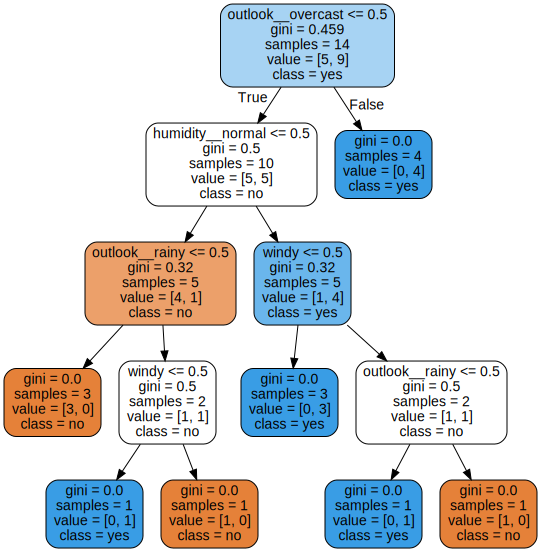

In [5]:
#########
# 2. Fit the classifier (default hyper-parameters)
#########
# instantiate the model
clf = DecisionTreeClassifier(random_state=1234, max_depth=None)# ,criterion = 'entropy')

# train the model on the data
model = clf.fit(xCoded, y)

#########
# 3. Visualize, interpret, and predict
#########
# create DOT data for drawing
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=xCoded.columns,  
                                class_names= ['no', 'yes'],
                                filled=True,
                                rounded = True)

# Draw the tree
graphviz.Source(dot_data, format="png") 

# Anatomy of a Binary Tree

## Tree Anatomy
- Nodes (root, decision, leaf)
- Edges (branch)

## Node Attributes
- Decision
- Gini/Entropy (purity)
- Samples
- Value
- Class

![https://www.aitimejournal.com/@akshay.chavan/a-comprehensive-guide-to-decision-tree-learning](tennis_tree.png)

# How is a tree built?

- Recursively identify the most important feature, then partition the data.
    - Variable splitting criteria (classification):
        - Entropy (average information gain of a split)
        - Gini impurity (node purity: the probability of incorrectly classifying a random item from that subset)
    - Variable splitting criteria (regression):
        - Variance reduction (total target variance reduction due to a split)

- Split the data into smaller and smaller subsets until:
    - Data is sufficiently homogeneous (classification)
    - Target variance is minimized (regression)
    - Stopping criteria is met (tree depth or leaf size)

# Choosing Splits: Gini Impurity

If there are J classes and i is a class in J and $p_i$ is the fraction of items labeled with class i, then Gini Impurity of a node is:

$$I_G(p) = \sum_{i=1}^{J}(p_i\sum_{k\ne i}^{}p_k) = \sum_{i=1}^{J}p_i(1-p_i) = 1 - \sum_{i=1}^{J}p_i^2$$

The range of $I_G(p)$ is \[0,1): 
- 0 indicates a pure node (no chance of incorrect classification) 
- ~1 indicates near certainty of incorrect classification.

To choose which variable to split on, the algorithm computes the impurity before the split and after the split for each variable, then chooses the maximum reduction in impurity.

## Example: Why did we first split on "Outlook" in the tennis dataset?

In [6]:
display(df.loc[df.outlook == 'overcast', :].sort_values('play'))
display(df.loc[df.outlook != 'overcast', :].sort_values('play'))

,outlook,temp,humidity,windy,play
2,overcast,hot,high,False,yes
6,overcast,cool,normal,True,yes
11,overcast,mild,high,True,yes
12,overcast,hot,normal,False,yes


,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
5,rainy,cool,normal,True,no
7,sunny,mild,high,False,no
13,rainy,mild,high,True,no
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes
10,sunny,mild,normal,True,yes


### Gini Impurity of Splitting on Outlook
Before split: $1-((\frac{5}{14})^2 + (\frac{9}{14})^2) = 0.459$  

"Overcast" branch: $1-((\frac{0}{4})^2 + (\frac{4}{4})^2) = 0.000$  

"Not Overcast" branch: $1-((\frac{5}{10})^2 + (\frac{5}{10})^2) = 0.500$  

Residual Gini Impurity: $0.459 - \frac{10}{14}(0.5) - \frac{4}{14}(0) = 0.102$

In [7]:
display(df.loc[df.humidity == 'high', :].sort_values('play'))
display(df.loc[df.humidity != 'high', :].sort_values('play'))

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
7,sunny,mild,high,False,no
13,rainy,mild,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
11,overcast,mild,high,True,yes


,outlook,temp,humidity,windy,play
5,rainy,cool,normal,True,no
4,rainy,cool,normal,False,yes
6,overcast,cool,normal,True,yes
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes
10,sunny,mild,normal,True,yes
12,overcast,hot,normal,False,yes


### Gini Impurity of Splitting on Humidity
Before split: $1-((\frac{7}{14})^2 + (\frac{7}{14})^2) = 0.500$  

"High" branch: $1-((\frac{4}{7})^2 + (\frac{3}{7})^2) = 0.489$  

"Normal" branch: $1-((\frac{1}{7})^2 + (\frac{6}{7})^2) = 0.245$   

Residual Gini Impurity: $0.459 - \frac{7}{14}(0.48) - \frac{7}{14}(0.48) = 0.133$

### So the Gini Impurity measure favors splitting on Outlook because it reduces impurity more than the other variables.<br>[These checks can be done in parallel!]

In [8]:
1-((5/10)**2 + (5/10)**2)
0.459 - (10/14)*0.5 

0.10185714285714287

In [9]:
1-((1/7)**2 + (6/7)**2)
0.5 - (7/14)*0.489 - (7/14)*0.245

0.133

In [10]:
1-((1/8)**2 + (1/8)**2 + (1/8)**2 + (1/8)**2 + (1/8)**2 + (1/8)**2 + (1/8)**2 + (1/8)**2)

0.875

In [11]:
1-((4/5)**2+(1/5)**2)

0.31999999999999984

# Predictions

In [12]:
# predict on new data
# let's say it is overcast, windy, normal humidity, and cool temp
sample_pred = model.predict([[True, 1, 1, 0, 1, 0, 0, 0, 1]])

print(f"Will JD play tennis? \nPrediction: {sample_pred}.")

Will JD play tennis? 
Prediction: ['yes'].


# Feature Importance

### One way to check feature importance...

In [13]:
# Adjust plot settings for the notebook
size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (12,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': 25}
plt.rcParams.update(params)

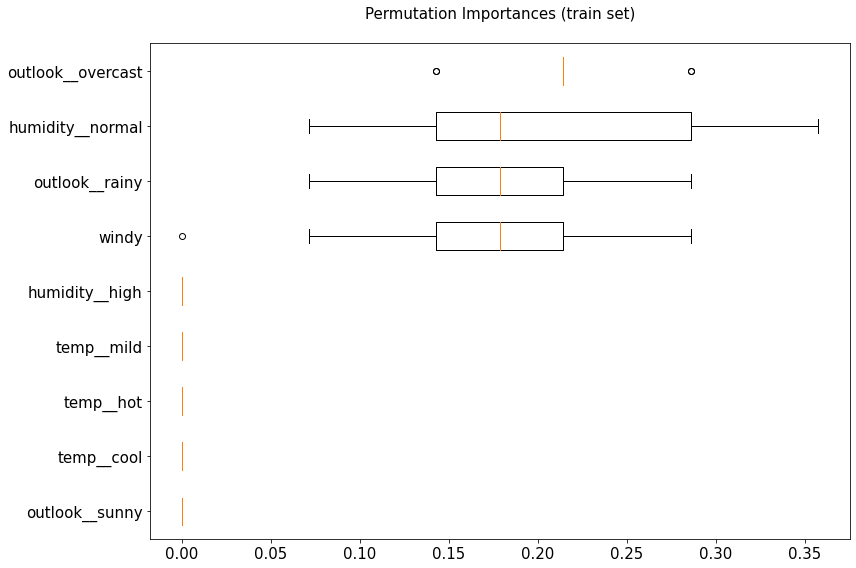

In [14]:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
from sklearn.inspection import permutation_importance

# run the permutations
result = permutation_importance(clf, xCoded, y, n_repeats=10,
                                random_state=42, n_jobs=2)
# sort variables based on importance
sorted_idx = result.importances_mean.argsort()

# plot the result
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=xCoded.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

# Why would you fit a binary tree instead of an ensemble model? 

### Binary Tree: Data Exploration
- Dealing with smaller datasets
- Building a simple explainable model
- Understand important variables
- Understand decision rules
- Identify important subsets of the data

### Ensemble Models: Predictions with Explainability
- Larger amounts of training data
- Want to make accurate predictions
- Want to understand variable importance

# Tree Ensemble Models

#### Key idea: train many binary trees and use a voting-based prediction.

- Bootstrap Aggregation ("bagging")
    - Sample the data (rows) with replacement, build base binary learners
    - Needs tree depth for performance

- Gradient Boosting (Ada Boost, XGBoost)
    - Train a simple binary tree (base learner)
    - Add subsequent trees that use the errors of existing trees to improve predictions
    - Incorrectly predicted rows are weighted higher for future trees
    - Gradient descent performed to minimize loss on new trees (reduce prediction error)
    - Needs many trees for performance (low hundreds)

- Random Forest
    - For each base learner:
        - Sample rows with replacement
        - Sample columns without replacement
    - Needs many trees to improve performance (low hundreds)

# Fit an XGBoost Model in Python
### Data: education dataset from kaggle

In [22]:
# education data set: https://www.kaggle.com/spscientist/students-performance-in-exams
# read in the data
df = pd.read_csv('StudentsPerformance.csv')

# show the data
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [16]:
# Split the data
X = df.drop(['math score', 'reading score', 'writing score'], axis=1)
y = df['math score']

# find the object column indices:
obj_is = [i for i in range(len(X.columns)) if X.dtypes[i] == 'object']

# One-hot encode the object columns, which is dtype object
cat_columns = X.iloc[:, obj_is].columns
xCoded = pd.get_dummies(X, prefix_sep="__", columns=cat_columns)

xCoded

,gender__female,gender__male,race/ethnicity__group A,race/ethnicity__group B,race/ethnicity__group C,race/ethnicity__group D,race/ethnicity__group E,parental level of education__associate's degree,parental level of education__bachelor's degree,parental level of education__high school,parental level of education__master's degree,parental level of education__some college,parental level of education__some high school,lunch__free/reduced,lunch__standard,test preparation course__completed,test preparation course__none
0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1
1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0
2,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
3,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
4,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0
996,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1
997,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0
998,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0


In [23]:
# imports
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

#break into training and test sets.
xTrain, xTest, yTrain, yTest = train_test_split(xCoded, y, test_size=0.20, random_state=1234)

# colsample_bytree is proportion of features to sample
# max_depth controls tree depth
# n_estimators is number of trees to use in ensemble
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.6,
                          max_depth = None, 
                          n_estimators = 200)  
xg_reg.fit(xTrain,yTrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
# predict on your test set
preds = xg_reg.predict(xTest)

# evaluate model performance
mse = mean_squared_error(yTest, preds)
print("RMSE: %f" % (math.sqrt(mse)))

RMSE: 15.247399


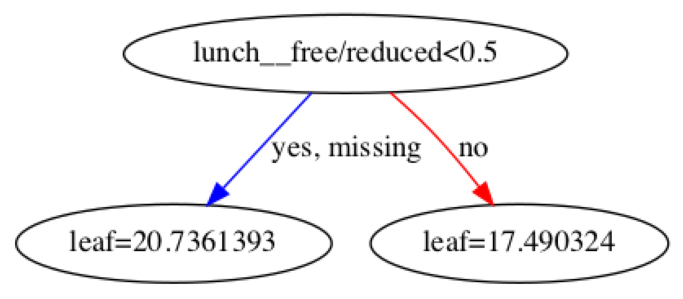

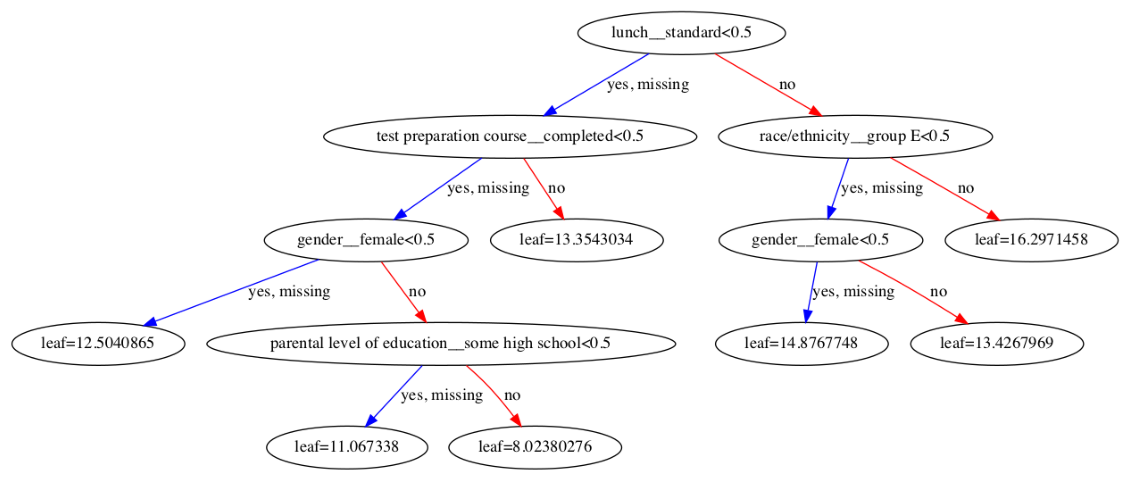

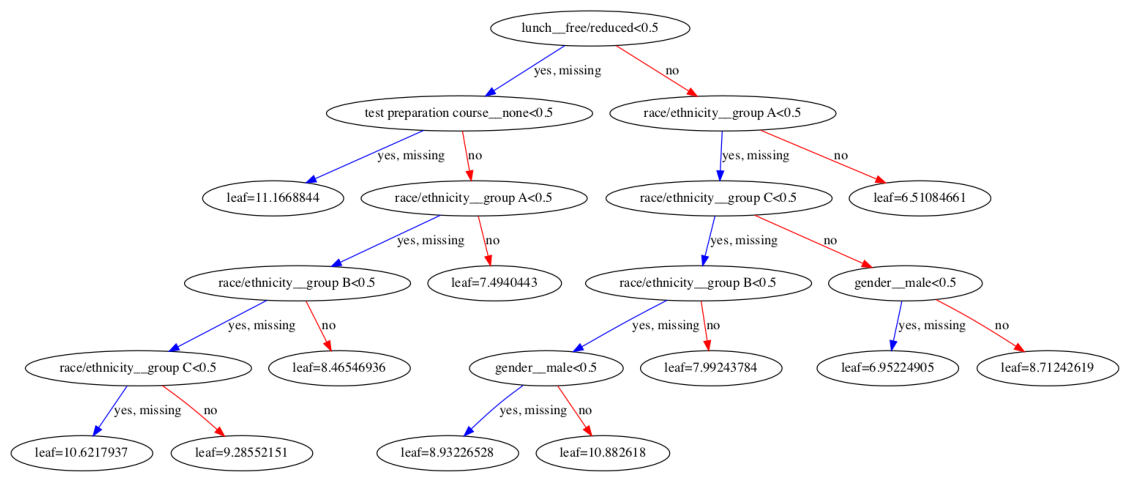

In [19]:
# inspect the trees of the model
for i in range(3):
    xgb.plot_tree(xg_reg, num_trees=i)
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.show()

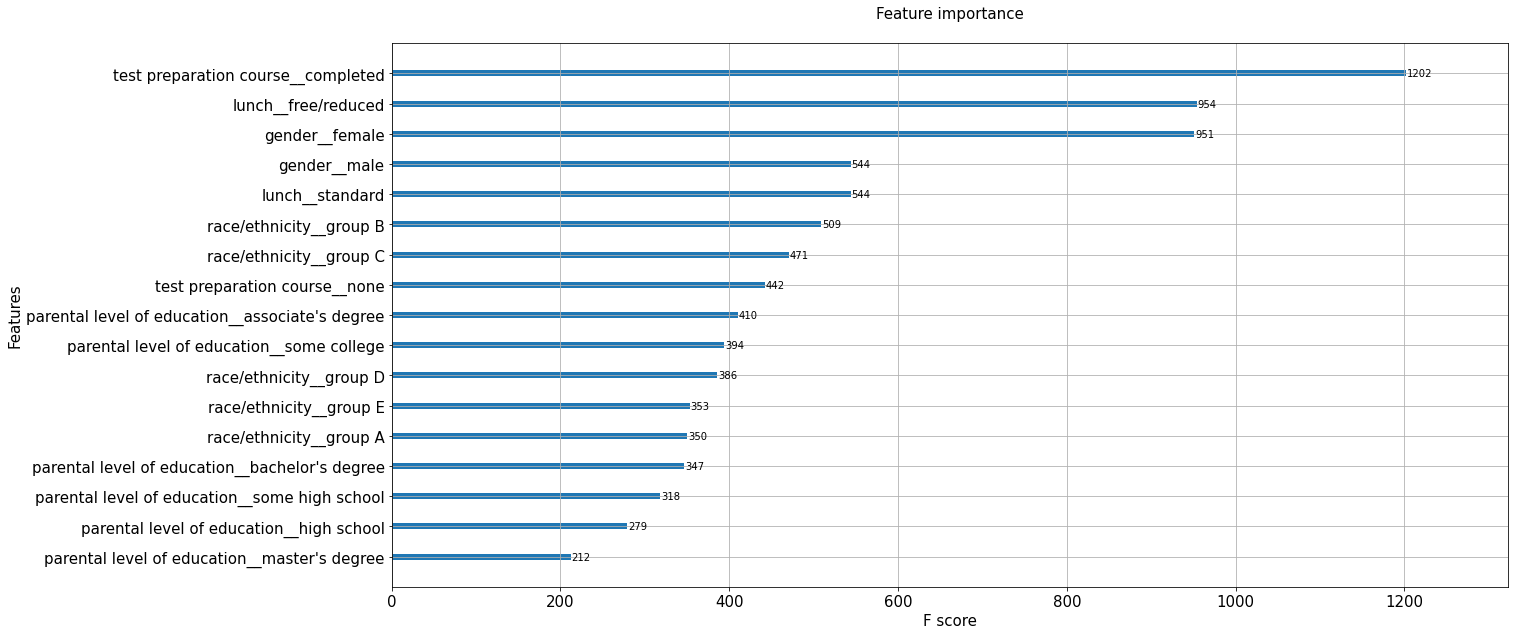

In [20]:
# plot the variable importances
xgb.plot_importance(xg_reg) 
plt.show()

# Conclusion 

### Benefits of CARTs
- Modeling flexibility
- Explainable and intuitive
    - I can choose model complexity very easily (limit max leave nodes or depth of tree) 
    - Visualization of the model or data partitioning
    - Decision Rules
- Accuracy/performance

### CART Caution
- Non-robustness to changes in training data
- Optimal tree is NP-complete (no way to find a solution quickly) so greedy heuristics are used
- Overfitting can occur without care
    - Pruning (pre and post)
    - Tree depth limits
    - Leaf size limits


## Treatment of the data
- Binary tree for exploration: 
    - use entire data set (caution - prevent overfitting)
    - sample from the data
    - train / test split
- Building an ensemble model
    - train / test split
    - k-fold cross validation

## Evaluation of Tree Ensembles
- Performance measures
    - classification
        - confusion matrix
        - accuracy, precision, recall, F1
    - regression
        - MAE, MSE, RMSE

# References
- "Machine Learning in Python" by Michael Bowles
- "An Introduction to Machine Learning" by Miroslav Kubat
- "Machine Learning with R, 2nd Edition" by Brett Lantz
- https://en.wikipedia.org/wiki/Decision_tree_learning
- https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/
- https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
- https://www.aitimejournal.com/@akshay.chavan/a-comprehensive-guide-to-decision-tree-learning
- https://rise.readthedocs.io/en/stable/


# Questions?